In [2]:
#activate conda env AutencoderTF env tf '2.10.0' , python 3.9.16
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print(sys.path)
sys.path.append('/root/LatentOE-AD')
from Additional_Code_BULE.utils.helper_functions  import plot_precision_recall_multi


root="/root/LatentOE-AD/DATA/fmnist_features/"

['/root/LatentOE-AD/Additional_Code_BULE', '/root/LatentOE-AD/Additional_Code_BULE/c', '/root/LatentOE-AD/Additional_Code_BULE/\\\\Users\\\\buehl\\\\git\\\\projects\\\\LatentOE-AD', '/root/anaconda3/envs/AutencoderTF/lib/python39.zip', '/root/anaconda3/envs/AutencoderTF/lib/python3.9', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/lib-dynload', '', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages']


/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-08-21 07:45:58.058386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 07:45:58.131218: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-21 07:45:58.148856: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Un

concatenate results from the alleresults file for the Bosch implementation

In [9]:
from Additional_Code_BULE.loe_utils.helperfunctions import concatenate_allresults
#concatenate_allresults('/root/LatentOE-AD/RESULTS/fmnist_0.001/',modelname='simple_refine',assumed_contamination=0.0)

compare two models to each other

|████████████████████████████████████████| 10/10 [100%] in 26.9s (0.35/s)       


/root/LatentOE-AD/Additional_Code_BULE/utils/helper_functions.py:304: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


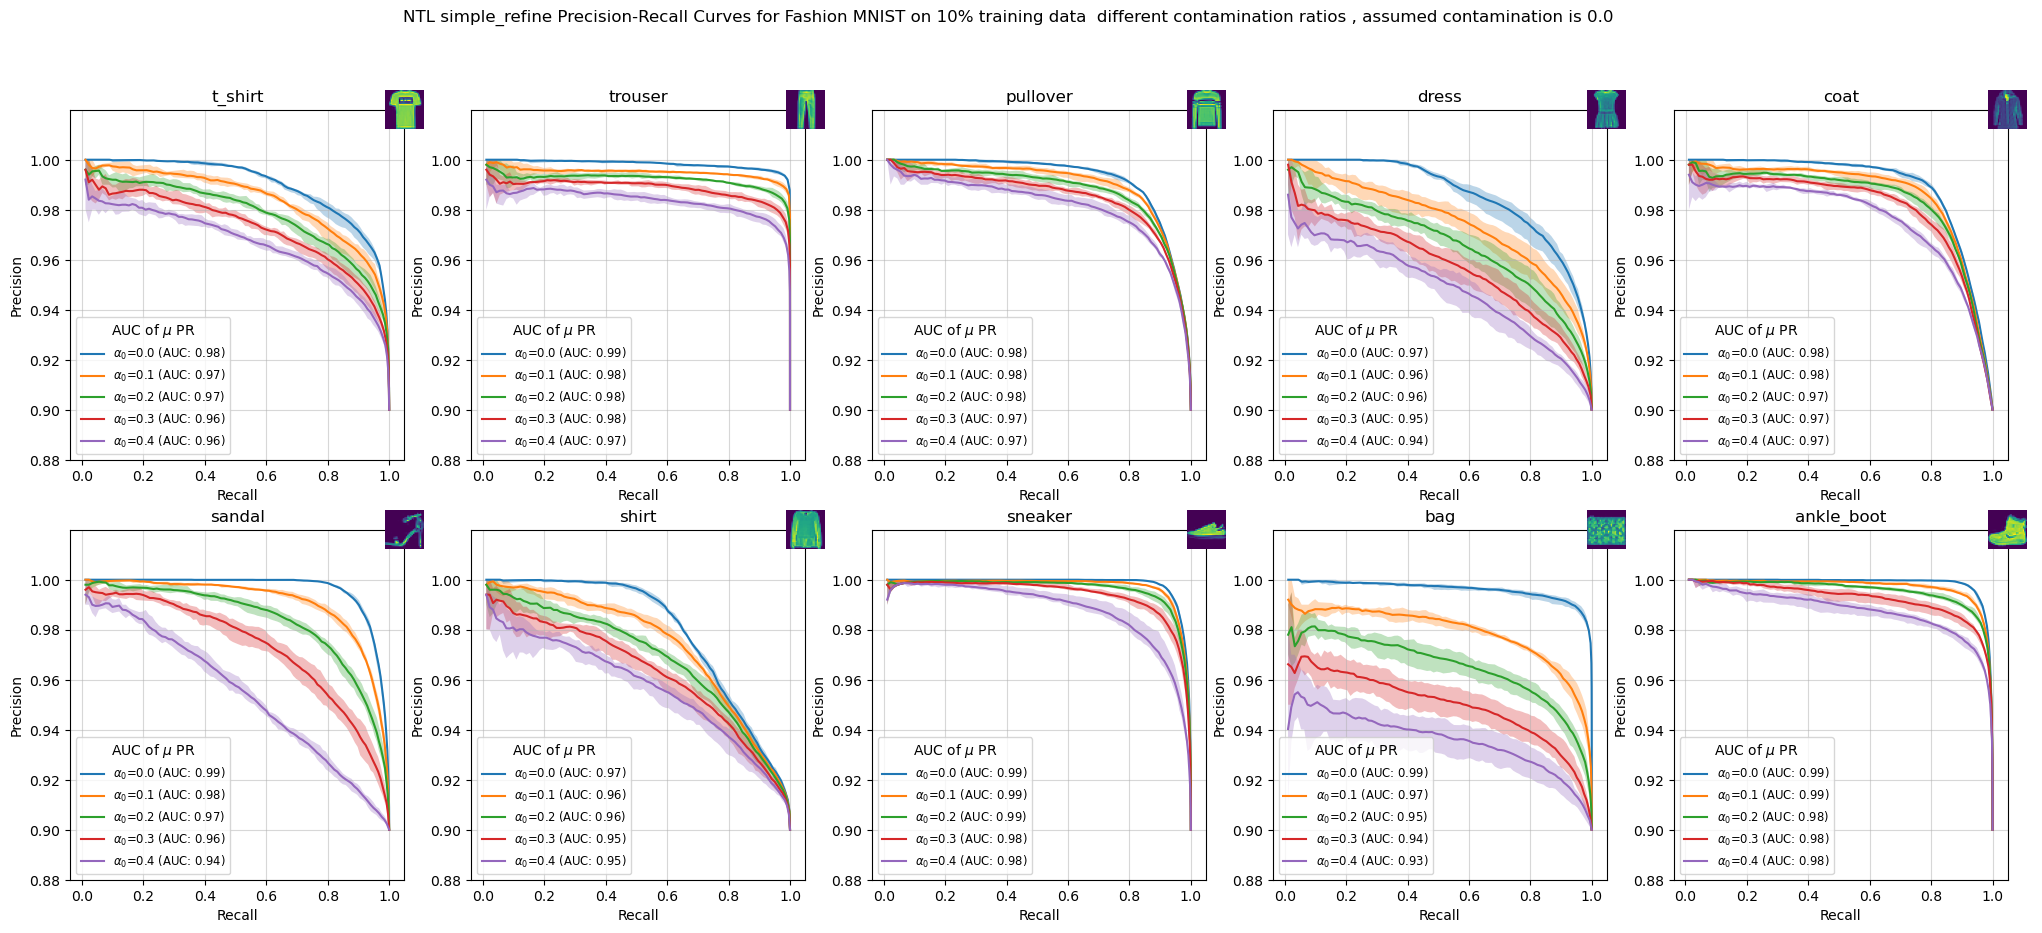

In [14]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist_0.1/simple_refine_assumed_contam_0.0_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0,0.1, 0.2,0.3,0.4]

title='NTL simple_refine Precision-Recall Curves for Fashion MNIST on 10% training data  different contamination ratios , assumed contamination is 0.0'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

In [3]:
from Additional_Code_BULE.utils.helper_functions import *

In [ ]:
def plot_precision_recall_multi_comparison(dataframe_list_1:list, dataframe_list_2:list, plot:bool=True, show_img:bool=False,
                                            contam_list:list=None, sklearn_pr:bool=None, title:str="plot", pred_y:str="mse_", pred_y2:str="mse_", min_max:bool=True )->None:
    """
    #TODO finepolish graphics blue and red are not very good to distinguish
    
    Calculates precision-recall for all the classes and contamination ratios for multiple datasets and different runs.
    draws it for two different models for comparison blue and red 
    Adds confidence bands to the precision-recall plot.
    plots the precision recall curves for all classes and contamination ratios
    # only for fmnist data

    Args:
        dataframe_list_1 (list): List of dataframes containing results for the first set of runs/datasets.
        dataframe_list_2 (list): List of dataframes containing results for the second set of runs/datasets.
        plot (bool): Whether to plot the precision-recall curves. Defaults to True. 
        show_img (bool): Whether to show sample images. Defaults to False.
        contam_list (list): List of contamination ratios. Defaults to None. If None, the contamination ratios are extracted from the dataframe.
        sklearn_pr (bool): Whether to use sklearn precision_recall_curve. Defaults to None. If None, the precision_recall function is used.
        title (str): Title of the plot. Defaults to "plot".
        pred_y (str): which metric to use. Defaults to "mse_". If pred_y = "pred_y" then pr goes to estimate the precision recall for the predicted y values with sklearn.
        min_max (bool): Whether to use min and max values for the confidence bands. Defaults to True. If False, the standard deviation is used.
    Returns:

    """
    if show_img:
        scaled_images = get_sample_img_fmnist()

    if contam_list is None:
        contam_list = list(set(dataframe_list_1[0]['contam_ratio']))

    label_names = ["t_shirt","trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","ankle_boot"]

    class_labels = list(set(dataframe_list_1[0]['normal_label'].astype('int32')))

    fig, axes = plt.subplots(2, 5)  # 2 rows and 5 columns for 10 subplots
    fig.suptitle(title)
    handles = []  # List to store plot handles for legend
    with alive_bar(len(class_labels),force_tty=True) as bar:
        for i, class_label in enumerate(class_labels):
            row = i // 5
            col = i % 5
            ax = axes[row, col]
            ax.set_title(f"{label_names[class_label]}")
            ax.set_xlabel("Recall")
            ax.set_ylabel("Precision")
            ax.set_ylim([0.88, 1.02])
            ax.set_yticks(np.arange(0.88, 1.01,0.02))
            ax.grid(True,alpha =0.5) 

            auc_values = []  # List to store AUC values
            handles = []  # List to store plot handles for legend

            for j, ratio in enumerate(contam_list):
                precision_runs = []  # List to store precision values for each run
                recall_runs = []  # List to store recall values for each run

                for dataframe in dataframe_list_1:
                    subset = dataframe[(dataframe["normal_label"] == class_label) & (dataframe["contam_ratio"] == ratio)]
                    if pred_y == "pred_y":
                        subset_pred_y = subset['y_pred_']
                        subset_anomaly = subset["anomaly_"]

                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y,pos_label=1)
                        else:  # does the same as sklearn_ not implemented for pred_y
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y,pos_label=1) 
                    else:
                        subset_mse = subset[pred_y]
                        subset_anomaly = subset["anomaly_"]
                    
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_mse)
                        else:
                            precision, recall = precision_recall(subset_mse, subset_anomaly, thresh_larger=False)
                    
                    precision_runs.append(precision)
                    recall_runs.append(recall)

                for dataframe in dataframe_list_2:
                    subset = dataframe[(dataframe["normal_label"] == class_label) & (dataframe["contam_ratio"] == ratio)]
                    if pred_y2 == "pred_y":
                        subset_pred_y = subset['y_pred_']
                        subset_anomaly = subset["anomaly_"]

                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y,pos_label=1)
                        else:  # does the same as sklearn_ not implemented for pred_y
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y,pos_label=1) 
                    else:
                        subset_mse = subset[pred_y2]
                        subset_anomaly = subset["anomaly_"]
                    
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_mse)
                        else:
                            precision, recall = precision_recall(subset_mse, subset_anomaly, thresh_larger=False)
                    
                    precision_runs.append(precision)
                    recall_runs.append(recall)

                # Calculate mean and confidence intervals for precision and recall
                precision_mean = np.mean(precision_runs, axis=0)
                precision_std = np.std(precision_runs, axis=0)
                recall_mean = np.mean(recall_runs, axis=0)
                recall_std = np.std(recall_runs, axis=0)
                
                if min_max:
                    precision_max = np.max(precision_runs, axis=0)
                    precision_min = np.min(precision_runs, axis=0)

                # Calculate AUC for mean precision-recall curve
                auc = calculate_auc(precision_mean, recall_mean)
                auc_values.append(auc)

                if plot:
                    # Add confidence bands to the plot
                    if min_max:
                        ax.fill_between(recall_mean, precision_min, precision_max, alpha=0.3, color='blue')
                    else:
                        ax.fill_between(recall_mean, precision_mean - 2 * precision_std, precision_mean + 2 * precision_std, alpha=0.3, color='blue')

                    if show_img:
                        imagebox = OffsetImage(scaled_images[class_label], zoom=1)
                        ab = AnnotationBbox(imagebox, (1, 1), xycoords='axes fraction', frameon=False)
                        ax.add_artist(ab)
                    handle = ax.plot(recall_mean, precision_mean, color='blue')  # Store the plot handle
                    handles.append(handle[0])

                for j, ratio in enumerate(contam_list):
                    precision_runs = []  # List to store precision values for each run
                    recall_runs = []  # List to store recall values for each run

                    for dataframe in dataframe_list_2:
                        subset = dataframe[(dataframe["normal_label"] == class_label) & (dataframe["contam_ratio"] == ratio)]
                        if pred_y2 == "pred_y":
                            subset_pred_y = subset['y_pred_']
                            subset_anomaly = subset["anomaly_"]

                            if sklearn_pr:
                                precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y,pos_label=1)
                            else:  # does the same as sklearn_ not implemented for pred_y
                                precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y,pos_label=1) 
                        else:
                            subset_mse = subset[pred_y2]
                            subset_anomaly = subset["anomaly_"]
                        
                            if sklearn_pr:
                                precision, recall, _ = precision_recall_curve(subset_anomaly, subset_mse)
                            else:
                                precision, recall = precision_recall(subset_mse, subset_anomaly, thresh_larger=False)
                        
                        precision_runs.append(precision)
                        recall_runs.append(recall)

                    # Calculate mean and confidence intervals for precision and recall
                    precision_mean = np.mean(precision_runs, axis=0)
                    precision_std = np.std(precision_runs, axis=0)
                    recall_mean = np.mean(recall_runs, axis=0)
                    recall_std = np.std(recall_runs, axis=0)
                    
                    if min_max:
                        precision_max = np.max(precision_runs, axis=0)
                        precision_min = np.min(precision_runs, axis=0)

                    # Calculate AUC for mean precision-recall curve
                    auc = calculate_auc(precision_mean, recall_mean)
                    auc_values.append(auc)

                    if plot:
                        # Add confidence bands to the plot
                        if min_max:
                            ax.fill_between(recall_mean, precision_min, precision_max, alpha=0.3, color='red')
                        else:
                            ax.fill_between(recall_mean, precision_mean - 2 * precision_std, precision_mean + 2 * precision_std, alpha=0.3, color='red')

                        if show_img:
                            imagebox = OffsetImage(scaled_images[class_label], zoom=1)
                            ab = AnnotationBbox(imagebox, (1, 1), xycoords='axes fraction', frameon=False)
                            ax.add_artist(ab)
                        handle = ax.plot(recall_mean, precision_mean, color='red')  # Store the plot handle
                        handles.append(handle[0])

            bar()
            # Add AUC values to the legend
            legend_labels = [f"Ratio: {ratio} (AUC: {auc:.2f})" for ratio, auc in zip(contam_list, auc_values)]
            ax.legend(handles, legend_labels, loc='best', title="Ratios", fontsize='small')

    if plot:
        plt.tight_layout()
        plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alive_progress import alive_bar
from sklearn.metrics import precision_recall_curve

# Note: Some functions like 'get_sample_img_fmnist', 'precision_recall', and 'calculate_auc' are not provided. 
# Ensure you have those functions defined elsewhere in your code.

def plot_precision_recall_multi_comparison(dataframe_list_1:list, dataframe_list_2:list, plot:bool=True, show_img:bool=False,
                                            contam_list:list=None, sklearn_pr:bool=None, title:str="plot", pred_y:str="mse_", pred_y2:str="mse_", min_max:bool=True ):

    if show_img:
        scaled_images = get_sample_img_fmnist()

    if contam_list is None:
        contam_list = list(set(dataframe_list_1[0]['contam_ratio']))

    label_names = ["t_shirt", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle_boot"]
    class_labels = list(set(dataframe_list_1[0]['normal_label'].astype('int32')))

    fig, axes = plt.subplots(2, 5)  # 2 rows and 5 columns for 10 subplots
    fig.suptitle(title)
    handles_model = []

    with alive_bar(len(class_labels), force_tty=True) as bar:
        for i, class_label in enumerate(class_labels):
            row = i // 5
            col = i % 5
            ax = axes[row, col]
            ax.set_title(label_names[class_label])
            ax.set_xlabel("Recall")
            ax.set_ylabel("Precision")
            ax.set_ylim([0.88, 1.02])
            ax.set_yticks(np.arange(0.88, 1.01, 0.02))
            ax.grid(True, alpha=0.5)

            auc_values = []
            handles = []

            for j, ratio in enumerate(contam_list):
                precision_runs_1 = []
                recall_runs_1 = []
                precision_runs_2 = []
                recall_runs_2 = []

                for dataframe in dataframe_list_1:
                    # Processing for dataframe_list_1
                    subset = dataframe[(dataframe["normal_label"] == class_label) & (dataframe["contam_ratio"] == ratio)]
                    if pred_y == "pred_y":
                        subset_pred_y = subset['y_pred_']
                        subset_anomaly = subset["anomaly_"]
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y, pos_label=1)
                        else:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y, pos_label=1)
                    else:
                        subset_mse = subset[pred_y]
                        subset_anomaly = subset["anomaly_"]
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_mse)
                        else:
                            precision, recall = precision_recall(subset_mse, subset_anomaly, thresh_larger=False)
                    precision_runs_1.append(precision)
                    recall_runs_1.append(recall)

                for dataframe in dataframe_list_2:
                    # Processing for dataframe_list_2
                    subset = dataframe[(dataframe["normal_label"] == class_label) & (dataframe["contam_ratio"] == ratio)]
                    if pred_y2 == "pred_y":
                        subset_pred_y = subset['y_pred_']
                        subset_anomaly = subset["anomaly_"]
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y, pos_label=1)
                        else:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y, pos_label=1)
                    else:
                        subset_mse = subset[pred_y2]
                        subset_anomaly = subset["anomaly_"]
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_mse)
                        else:
                            precision, recall = precision_recall(subset_mse, subset_anomaly, thresh_larger=False)
                    precision_runs_2.append(precision)
                    recall_runs_2.append(recall)

                # Calculations for dataframe_list_1
                precision_mean_1 = np.mean(precision_runs_1, axis=0)
                recall_mean_1 = np.mean(recall_runs_1, axis=0)
                if min_max:
                    precision_max_1 = np.max(precision_runs_1, axis=0)
                    precision_min_1 = np.min(precision_runs_1, axis=0)

                # Calculations for dataframe_list_2
                precision_mean_2 = np.mean(precision_runs_2, axis=0)
                recall_mean_2 = np.mean(recall_runs_2, axis=0)
                if min_max:
                    precision_max_2 = np.max(precision_runs_2, axis=0)
                    precision_min_2 = np.min(precision_runs_2, axis=0)

                # Plotting for dataframe_list_1
                if plot:
                    if min_max:
                        ax.fill_between(recall_mean_1, precision_min_1, precision_max_1, alpha=0.3, color='blue')
                    handle = ax.plot(recall_mean_1, precision_mean_1, color='blue', label='Model 1')
                    if i == 0:
                        handles_model.append(handle[0])

                # Plotting for dataframe_list_2
                if plot:
                    if min_max:
                        ax.fill_between(recall_mean_2, precision_min_2, precision_max_2, alpha=0.3, color='red')
                    handle = ax.plot(recall_mean_2, precision_mean_2, color='red', label='Model 2')
                    if i == 0:
                        handles_model.append(handle[0])

            bar()

            # Add AUC values to the legend for each contamination ratio
            legend_labels = [f"Ratio: {ratio} (AUC: {auc:.2f})" for ratio, auc in zip(contam_list, auc_values)]
            ax.legend(handles, legend_labels, loc='upper left', title="Ratios", fontsize='small')

    # Final legend for models
    fig.legend(handles_model, ["Model 1", "Model 2"], loc='lower center', ncol=2)

    if plot:
        plt.tight_layout()
        plt.show()


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alive_progress import alive_bar
from sklearn.metrics import precision_recall_curve

# Note: Some functions like 'get_sample_img_fmnist', 'precision_recall', and 'calculate_auc' are not provided. 
# Ensure you have those functions defined elsewhere in your code.

def plot_precision_recall_multi_comparison(dataframe_list_1:list, dataframe_list_2:list, plot:bool=True, show_img:bool=False,
                                            contam_list:list=None, sklearn_pr:bool=None, title:str="plot", pred_y:str="mse_", pred_y2:str="mse_", min_max:bool=True ):

    if show_img:
        scaled_images = get_sample_img_fmnist()

    if contam_list is None:
        contam_list = list(set(dataframe_list_1[0]['contam_ratio']))

    label_names = ["t_shirt", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle_boot"]
    class_labels = list(set(dataframe_list_1[0]['normal_label'].astype('int32')))

    fig, axes = plt.subplots(2, 5)  # 2 rows and 5 columns for 10 subplots
    fig.suptitle(title,fontsize=20)
    handles_model = []

    with alive_bar(len(class_labels), force_tty=True) as bar:
        for i, class_label in enumerate(class_labels):
            row = i // 5
            col = i % 5
            ax = axes[row, col]
            ax.set_title(label_names[class_label],fontsize=16)
            ax.set_xlabel("Recall")
            ax.set_ylabel("Precision")
            ax.set_ylim([0.88, 1.02])
            ax.set_yticks(np.arange(0.88, 1.01, 0.02))
            ax.grid(True, alpha=0.5)

            auc_values = []
            handles = []

            for j, ratio in enumerate(contam_list):
                precision_runs_1 = []
                recall_runs_1 = []
                precision_runs_2 = []
                recall_runs_2 = []

                for dataframe in dataframe_list_1:
                    # Processing for dataframe_list_1
                    subset = dataframe[(dataframe["normal_label"] == class_label) & (dataframe["contam_ratio"] == ratio)]
                    if pred_y == "pred_y":
                        subset_pred_y = subset['y_pred_']
                        subset_anomaly = subset["anomaly_"]
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y, pos_label=1)
                        else:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y, pos_label=1)
                    else:
                        subset_mse = subset[pred_y]
                        subset_anomaly = subset["anomaly_"]
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_mse)
                        else:
                            precision, recall = precision_recall(subset_mse, subset_anomaly, thresh_larger=False)
                    precision_runs_1.append(precision)
                    recall_runs_1.append(recall)

                for dataframe in dataframe_list_2:
                    # Processing for dataframe_list_2
                    subset = dataframe[(dataframe["normal_label"] == class_label) & (dataframe["contam_ratio"] == ratio)]
                    if pred_y2 == "pred_y":
                        subset_pred_y = subset['y_pred_']
                        subset_anomaly = subset["anomaly_"]
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y, pos_label=1)
                        else:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y, pos_label=1)
                    else:
                        subset_mse = subset[pred_y2]
                        subset_anomaly = subset["anomaly_"]
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_mse)
                        else:
                            precision, recall = precision_recall(subset_mse, subset_anomaly, thresh_larger=False)
                    precision_runs_2.append(precision)
                    recall_runs_2.append(recall)

                # Calculations for dataframe_list_1
                precision_mean_1 = np.mean(precision_runs_1, axis=0)
                recall_mean_1 = np.mean(recall_runs_1, axis=0)
                if min_max:
                    precision_max_1 = np.max(precision_runs_1, axis=0)
                    precision_min_1 = np.min(precision_runs_1, axis=0)

                # Calculations for dataframe_list_2
                precision_mean_2 = np.mean(precision_runs_2, axis=0)
                recall_mean_2 = np.mean(recall_runs_2, axis=0)
                if min_max:
                    precision_max_2 = np.max(precision_runs_2, axis=0)
                    precision_min_2 = np.min(precision_runs_2, axis=0)

                # Plotting for dataframe_list_1
                if plot:
                    if min_max:
                        ax.fill_between(recall_mean_1, precision_min_1, precision_max_1, alpha=0.3, color='blue')
                    handle = ax.plot(recall_mean_1, precision_mean_1, color='blue', label='Model 1')
                    if i == 0:
                        handles_model.append(handle[0])

                # Plotting for dataframe_list_2
                if plot:
                    if min_max:
                        ax.fill_between(recall_mean_2, precision_min_2, precision_max_2, alpha=0.3, color='red')
                    handle = ax.plot(recall_mean_2, precision_mean_2, color='red', label='Model 2')
                    if i == 0:
                        handles_model.append(handle[0])

            bar()

            # # Add AUC values to the legend for each contamination ratio
            # legend_labels = [f"Ratio: {ratio} (AUC: {auc:.2f})" for ratio, auc in zip(contam_list, auc_values)]
            # ax.legend(handles, legend_labels, loc='upper left', title="Ratios", fontsize='small')

    # Final legend for models
    fig.legend(handles_model, ["Autoencoder", "NTL Blind"], loc='lower center', ncol=2,fontsize=18, bbox_to_anchor=(0.5, -0.1))

    if plot:
        plt.tight_layout()
        plt.show()


|████████████████████████████████████████| 10/10 [100%] in 54.9s (0.17/s)       


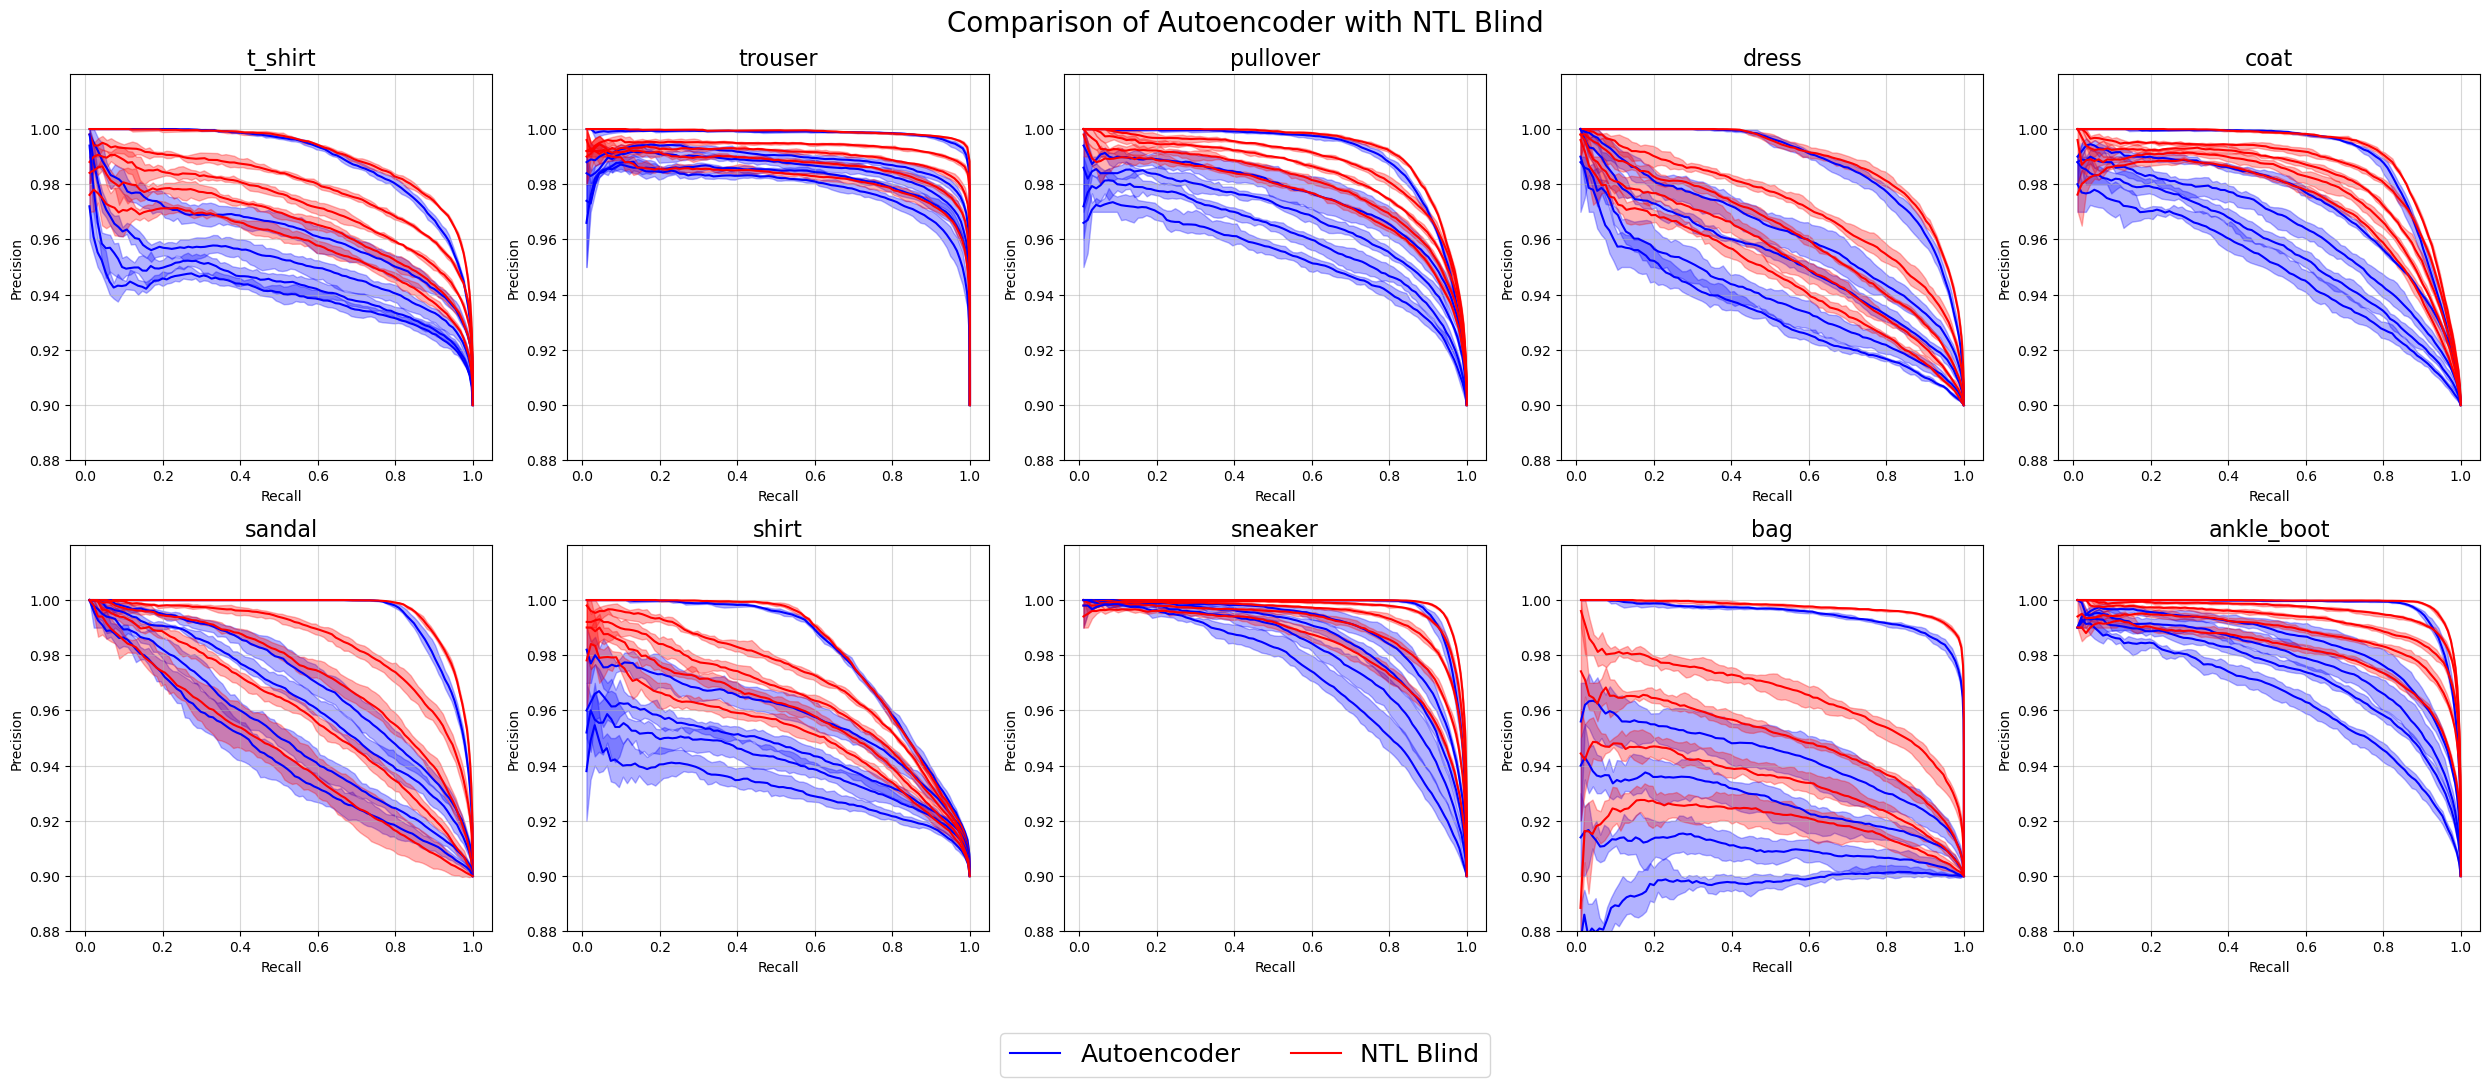

In [23]:

# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/AE3")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    # Create an instance of MinMaxScaler
    result_= pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name))
    dataframe_list.append(result_)



MODEL_RESULT_PATH2 = Path(r"/root/LatentOE-AD/RESULTS/fmnist/blind_allresults")

# load the diffent runs in a list
nameslist2,dataframe_list2=[name for name in os.listdir(MODEL_RESULT_PATH2) if "allresults_run_"in name],[]
for name in nameslist2:
    # Create an instance of MinMaxScaler
    result_= pd.read_pickle(os.path.join(MODEL_RESULT_PATH2,name))
    dataframe_list2.append(result_)
# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3, 0.4]

#contam_list = [0.0]


title='Comparison of Autoencoder with NTL Blind'

#plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')
plot_precision_recall_multi_comparison(dataframe_list, dataframe_list2, show_img=True, contam_list=contam_list, title=title,pred_y='mse_', pred_y2='score_' )


In [2]:
#activate conda env AutencoderTF env tf '2.10.0' , python 3.9.16
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print(sys.path)
sys.path.append('/root/LatentOE-AD')
from Additional_Code_BULE.loe_utils.plots_from_paper_functions import *


root="/root/LatentOE-AD/DATA/fmnist_features/"

['/root/LatentOE-AD/Additional_Code_BULE', '/root/LatentOE-AD/Additional_Code_BULE/c', '/root/LatentOE-AD/Additional_Code_BULE/\\\\Users\\\\buehl\\\\git\\\\projects\\\\LatentOE-AD', '/root/anaconda3/envs/AutencoderTF/lib/python39.zip', '/root/anaconda3/envs/AutencoderTF/lib/python3.9', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/lib-dynload', '', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages']


/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


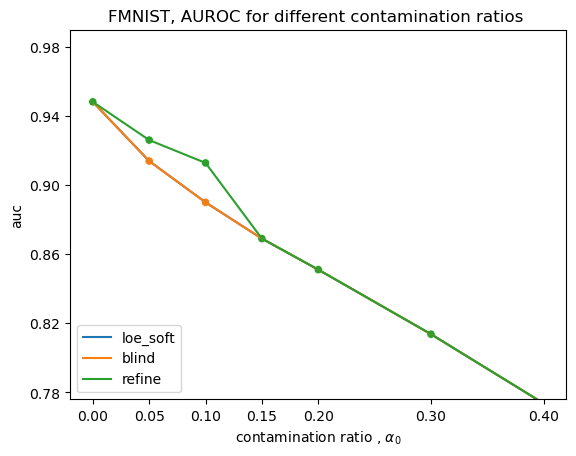

,auc,contam,model
0,0.913974,0.05,loe_soft
1,0.948223,0.00,loe_soft
2,0.869049,0.15,loe_soft
3,0.890040,0.10,loe_soft
4,0.851080,0.20,loe_soft
5,0.813716,0.30,loe_soft
6,0.773588,0.40,loe_soft
0,0.913974,0.05,blind
1,0.913974,0.05,blind
2,0.948223,0.00,blind


In [3]:
#from Additional_Code_BULE.loe_utils.plots_from_paper_functions import *
# loe_hard_no are the models where the loss gets the contamination ratio from the dataset
folderpath='/root/LatentOE-AD/RESULTS/fmnist/'
#loss_list=['loe_hard_no','loe_soft_no','blind','refine_no']
loss_list=['loe_soft','blind','refine']
contam_list=[0.0,0.05,0.1,0.15,0.2,0.3,0.4]
assumed_contamination=0.0
df=get_dataframe_from_results(contam_list,folderpath,loss_list,assumed_contamination)

plot_lineplots(df)
df



In [14]:
def get_path_from_abspathlist(model:str,a0:float,a:float,abspath_list_results:list)->str:
    """
    returns the path of the results file for a given model and contamination ratio
    param model: string of the model
    param a0: float of the assumed contamination
    param a: float of the real contamination
    param abspath_list_results: list of absolute paths to the results files
    
    return: string of the path
    """
    
    for path in abspath_list_results:
        if f'{a0}_{model}_{a}_' in path:
            return path
    else:
        return None


In [15]:
def get_heatmap_df(folderpath:str,model:str,contlist:list,mode:str='all')->pd.DataFrame:
    """
    gets for each of the values  j and k in contlist the model with contlist[i]_model_contlist[k] and returns a dataframe with the results
    param folderpath: string of the folderpath where the results are stored
    param model: string of the model
    param contlist: list of contamination ratios
    param mode: string of the mode, can be 'all','min' or 'max'    
    return: pd.DataFrame with the results oreder by alpha0
    
    """

    alpha0 = sorted(np.round(list(np.round(contlist, 2)) * len(contlist), 2))
    alpha = np.round(list(np.round(contlist, 2)) * len(contlist), 2)
    loss_list=[model]*len(alpha0)

    modelname_list=[f'{a0}_{loss}_{a}_' for a0,a,loss in zip(alpha0,alpha,loss_list)]
    abspath_list_results=[folderpath +file+ '/assessment_results.json' for file in os.listdir(folderpath)if file in modelname_list ]
    abspath_list_results=set(abspath_list_results)
    auc_list=[]
    for a0,a in zip(alpha0,alpha):
        filepath=get_path_from_abspathlist(model,a0,a,abspath_list_results)
        print(filepath)
        with open(filepath) as f:
            results = f.read()
            if mode=='all':
                auc = json.loads(results)['avg_TS_auc_all']
            if mode=='min':
                json_results = json.loads(results)
                auc= json_get_min(json_results)
            if mode=='max':
                json_results = json.loads(results)
                auc= json_get_max(json_results)
            auc_list.append(auc)

    df = pd.DataFrame({'alpha0': alpha0, 'alpha': alpha, 'auc': auc_list})
    return df

/root/LatentOE-AD/RESULTS/fmnist/0.0_loe_hard_0.0_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.0_loe_hard_0.05_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.0_loe_hard_0.1_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.0_loe_hard_0.15_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.0_loe_hard_0.2_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.0_loe_hard_0.3_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.0_loe_hard_0.4_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.05_loe_hard_0.0_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.05_loe_hard_0.05_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.05_loe_hard_0.1_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.05_loe_hard_0.15_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.05_loe_hard_0.2_/assessment_results.json
/root/LatentOE-AD/RESULTS/fmnist/0.05_loe_hard_0.3_/assessment_results.json
/root/LatentOE-

/root/LatentOE-AD/Additional_Code_BULE/loe_utils/plots_from_paper_functions.py:183: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_pivot = df.pivot('alpha0','alpha',  'auc')


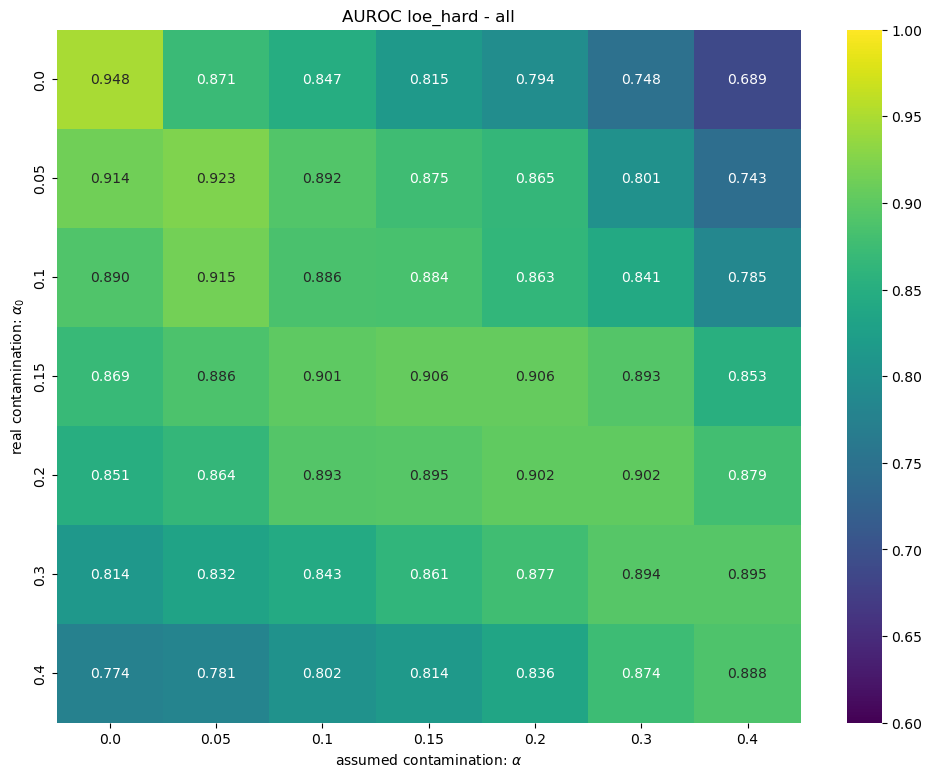

In [16]:
folderpath='/root/LatentOE-AD/RESULTS/fmnist/'
model='loe_hard'
mode='all'
contlist=[0.0,0.05,0.1,0.15,0.2,0.3,0.4]
#contlist=[0.0,0.05,0.1,0.15,0.2]
df=get_heatmap_df(folderpath,model,contlist,mode=mode)
plot_heatmap(df,title=f'AUROC {model} - {mode}',vmin_max=(0.6,1))

[0.   0.05 0.1  0.15 0.2  0.   0.05 0.1  0.15 0.2  0.   0.05 0.1  0.15
 0.2  0.   0.05 0.1  0.15 0.2  0.   0.05 0.1  0.15 0.2 ] [0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.2, 0.2, 0.2, 0.2] ['loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft', 'loe_soft']
['/root/LatentOE-AD/RESULTS/fmnist/0.05_loe_soft_0.0_/assessment_results.json', '/root/LatentOE-AD/RESULTS/fmnist/0.2_loe_soft_0.05_/assessment_results.json', '/root/LatentOE-AD/RESULTS/fmnist/0.1_loe_soft_0.1_/assessment_results.json', '/root/LatentOE-AD/RESULTS/fmnist/0.15_loe_soft_0.2_/assessment_results.json', '/root/LatentOE-AD/RESULTS/fmnist/0.1_loe_soft_0.15_/assessment_results.json', '/root/LatentOE-AD/RESULTS/fmnist/0.0_lo

/tmp/ipykernel_129892/627127781.py:184: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_pivot = df.pivot('alpha0','alpha',  'auc')


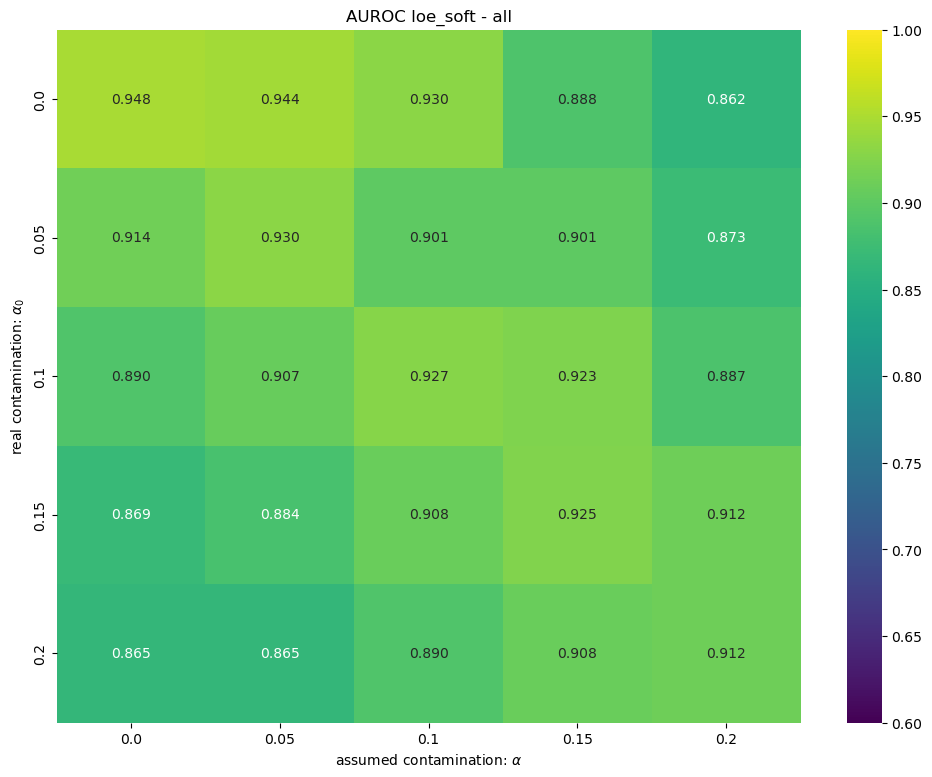

,alpha0,alpha,auc
0,0.00,0.00,0.948223
1,0.05,0.00,0.913974
2,0.10,0.00,0.890040
3,0.15,0.00,0.869049
4,0.20,0.00,0.864717
5,0.00,0.05,0.944183
6,0.05,0.05,0.930353
7,0.10,0.05,0.907076
8,0.15,0.05,0.883571
9,0.20,0.05,0.864717


In [3]:
#from Additional_Code_BULE.loe_utils.plots_from_paper_functions import *

folderpath='/root/LatentOE-AD/RESULTS/fmnist_0.6//'
model='loe_soft'
mode='all'
contlist=np.arange(0.0, 0.45, 0.1)# for which contamination ratios we want to see the results
contlist=[0.0,0.05,0.1,0.15,0.2]

df=get_heatmap_df(folderpath,model,contlist,mode=mode)


plot_heatmap(df,title=f'AUROC {model} - {mode}',vmin_max=(0.6,1))
df


In [9]:
df

,auc,contam,model
0,0.913974,0.05,loe_soft
1,0.948223,0.00,loe_soft
2,0.869049,0.15,loe_soft
3,0.890040,0.10,loe_soft
4,0.851080,0.20,loe_soft
5,0.813716,0.30,loe_soft
6,0.773588,0.40,loe_soft
0,0.913974,0.05,blind
1,0.948223,0.00,blind
2,0.869049,0.15,blind


In [1]:
# helperfuctions 

import pandas as pd
import seaborn as sns
import os 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time
from alive_progress import  alive_bar

from pathlib import Path
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.metrics import precision_recall_curve

from tensorflow.keras.datasets import fashion_mnist
from PIL import Image

from sklearn.metrics import RocCurveDisplay, roc_curve

/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-07-17 08:15:58.843990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 08:15:58.914968: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-17 08:15:58.931793: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Un

on 0: [0.00000000e+00 1.11111111e-04 3.36666667e-02 ... 1.00000000e+00          
       1.00000000e+00 1.00000000e+00]
on 0: [0.00000000e+00 1.11111111e-04 2.07777778e-02 ... 1.00000000e+00          
       1.00000000e+00 1.00000000e+00]
on 0: [0.00000000e+00 1.11111111e-04 1.05555556e-02 ... 1.00000000e+00          
       1.00000000e+00 1.00000000e+00]
on 0: [0.00000000e+00 1.11111111e-04 1.62222222e-02 ... 1.00000000e+00          
       1.00000000e+00 1.00000000e+00]
on 0: [0.00000000e+00 1.11111111e-04 1.84444444e-02 ... 1.00000000e+00          
       1.00000000e+00 1.00000000e+00]
|⚠︎                                       | (!) 0/10 [0%] in 0.0s (0.00/s)       


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

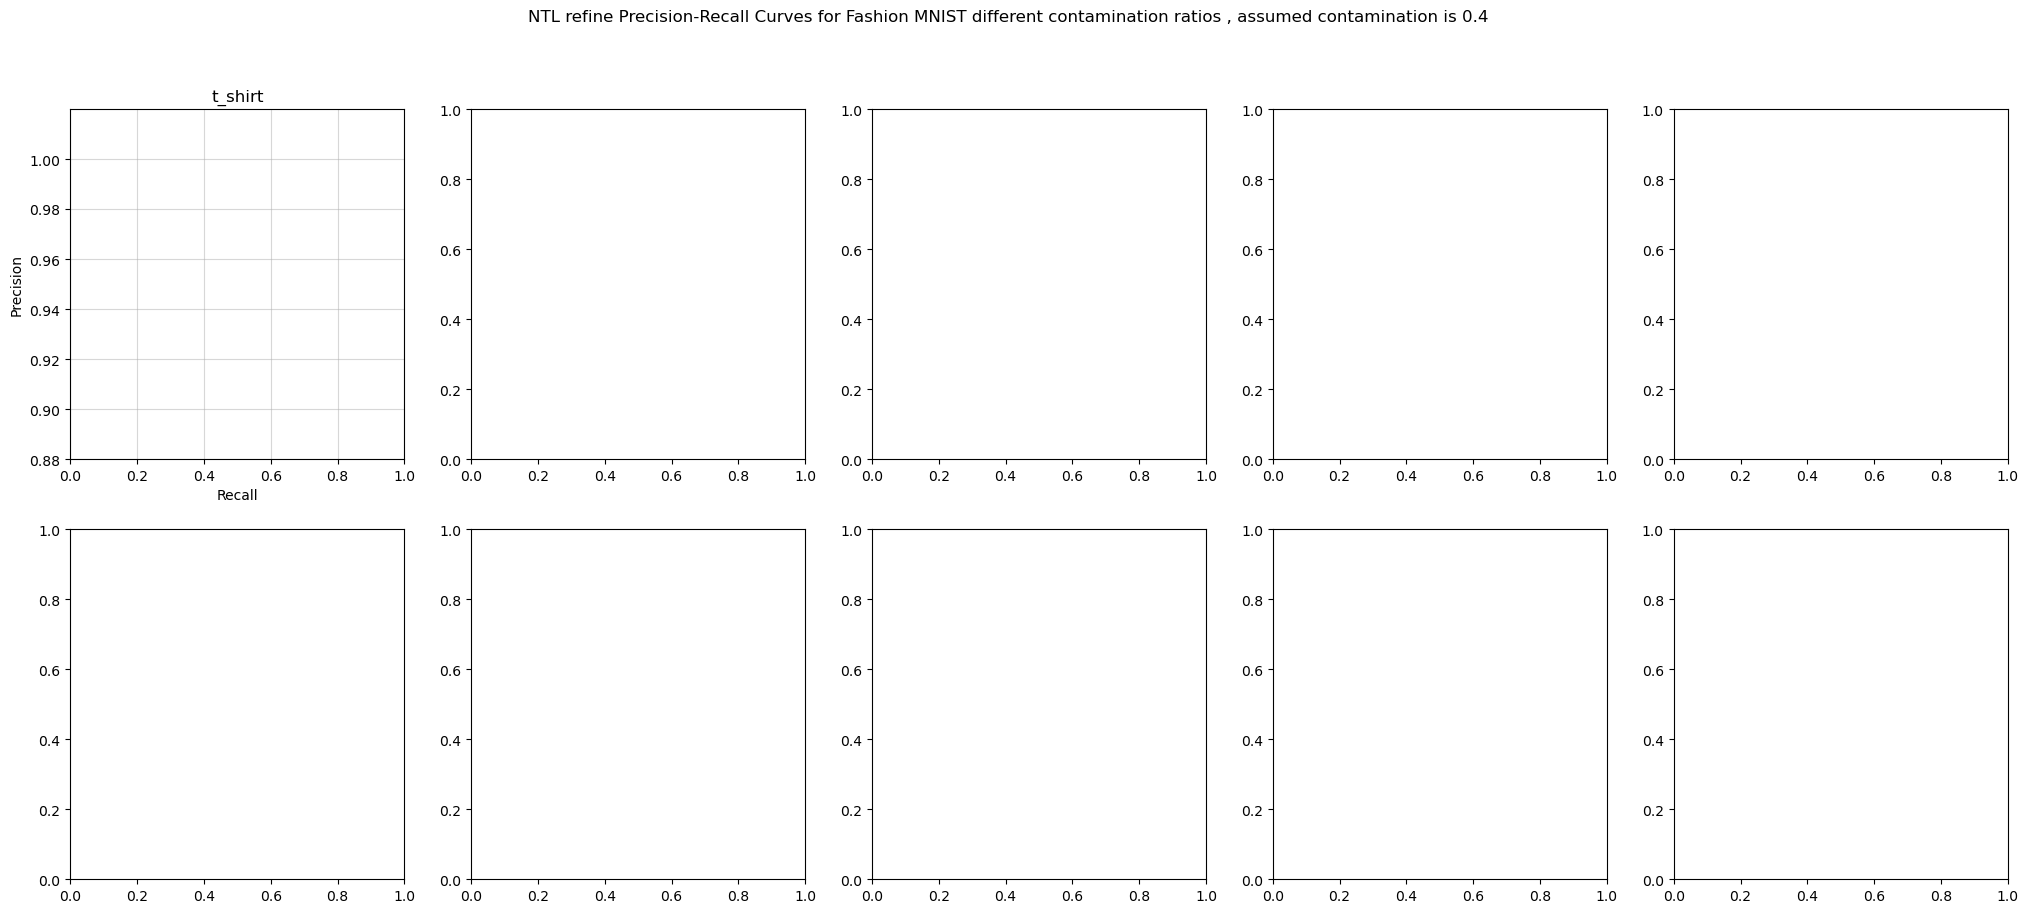

In [7]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/refine_assumed_contam_0.4_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL refine Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.4'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=True,title=title,pred_y='score_')

In [6]:
def plot_precision_recall_multi(dataframe_list:list, plot:bool=True, show_img:bool=False,contam_list:list=None,sklearn_pr:bool=None,title:str="plot",pred_y:str="mse_",min_max:bool=True )->None:
    """
    Calculates precision-recall for all the classes and contamination ratios for multiple datasets and different runs.
    Adds confidence bands to the precision-recall plot.
    plots the precision recall curves for all classes and contamination ratios
    # only for fmnist data

    Args:
        dataframe_list (list): List of dataframes containing results for different runs/datasets.
        plot (bool): Whether to plot the precision-recall curves. Defaults to True. 
        show_img (bool): Whether to show sample images. Defaults to False.
        contam_list (list): List of contamination ratios. Defaults to None. If None, the contamination ratios are extracted from the dataframe.
        sklearn_pr (bool): Whether to use sklearn precision_recall_curve. Defaults to None. If None, the precision_recall function is used.
        title (str): Title of the plot. Defaults to "plot".
        pred_y (str): which metric to use . Defaults to "mse_". If pred_y = "pred_y" then pr goes to estimate the precision recall for the predicted y values with sklearn.
        min_max (bool): Whether to use min and max values for the confidence bands. Defaults to True. If False, the standard deviation is used.
    Returns:

    """
    if show_img:
        scaled_images=get_sample_img_fmnist()

    if contam_list is None:
        contam_list = list(set(dataframe_list[0]['contam_ratio']))

    label_names= ["t_shirt","trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","ankle_boot"]

    class_labels = list(set(dataframe_list[0]['normal_label'].astype('int32')))
    

    fig, axes = plt.subplots(2, 5)  # 2 rows and 5 columns for 10 subplots
    fig.suptitle(title)
    handles = []  # List to store plot handles for legend
    with alive_bar(len(class_labels),force_tty=True) as bar:
        for i, class_label in enumerate(class_labels):
            row = i // 5
            col = i % 5
            ax = axes[row, col]
            ax.set_title(f"{label_names[class_label]}")
            ax.set_xlabel("Recall")
            ax.set_ylabel("Precision")
            ax.set_ylim([0.88, 1.02])
            ax.set_yticks(np.arange(0.88, 1.01,0.02))
            ax.grid(True,alpha =0.5) 

            auc_values = []  # List to store AUC values
            handles = []  # List to store plot handles for legend

            for j, ratio in enumerate(contam_list):
                precision_runs = []  # List to store precision values for each run
                recall_runs = []  # List to store recall values for each run

                for dataframe in dataframe_list:
                    subset = dataframe[(dataframe["normal_label"] == class_label) & (dataframe["contam_ratio"] == ratio)]
                    if pred_y == "pred_y":
                        subset_pred_y = subset['y_pred_']
                        subset_anomaly = subset["anomaly_"]

                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y,pos_label=1)
                        else:# does the same as sklearn_ not implementes for pred_y
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y,pos_label=1) 
                    else:
                        subset_mse = subset[pred_y]
                        subset_anomaly = subset["anomaly_"]
                    
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_mse)    # recall:  sensitivity, , hit rate, or true positive rate (TPR)
                
                            fpr, tpr, _ = roc_curve(subset_anomaly, subset_mse, pos_label=1)
                            print(tpr)
                        else:
                            precision, recall = precision_recall(subset_mse, subset_anomaly, thresh_larger=False)

                    
            
                    
                    precision_runs.append(tpr)
                    recall_runs.append(fpr)         
                



                # Calculate mean and confidence intervals for precision and recall
                precision_mean = np.mean(precision_runs, axis=0)
                precision_std = np.std(precision_runs, axis=0)
                recall_mean = np.mean(recall_runs, axis=0)
                recall_std = np.std(recall_runs, axis=0)
                
                if min_max:
                    precision_max = np.max(precision_runs, axis=0)
                    precision_min = np.min(precision_runs, axis=0)

                # Calculate AUC for mean precision-recall curve
                auc = calculate_auc(precision_mean, recall_mean)
                auc_values.append(auc)


                if plot:
                    # Add confidence bands to the plot
                    if min_max:
                        ax.fill_between(recall_mean, precision_min, precision_max,
                                        alpha=0.3)
                    else:
                        ax.fill_between(recall_mean, precision_mean - 2 * precision_std, precision_mean + 2 * precision_std,
                                        alpha=0.3)

                    if show_img:
                        imagebox = OffsetImage(scaled_images[class_label], zoom=1)
                        ab = AnnotationBbox(imagebox, (1, 1), xycoords='axes fraction', frameon=False)
                        ax.add_artist(ab)
                    handle = ax.plot(recall_mean, precision_mean)  # Store the plot handle
                    handles.append(handle[0])

            bar()
            # Add AUC values to the legend
            legend_labels = [r"$\alpha_{0}$=" + f"{ratio} (AUC: {auc:.2f})" for ratio, auc in zip(contam_list, auc_values)]
            ax.legend(handles, legend_labels, loc='best', title=r"AUC of $\mu$ PR",fontsize='small')

    if plot:
        plt.tight_layout()
        plt.show()


def get_sample_img_fmnist()->list:
    """
    Returns a list of sample images per class from the FMNIST dataset.
    """
    # Load the FMNIST dataset
    (x_train, y_train), _ = fashion_mnist.load_data()
    # Create a list to store the scaled down images
    scaled_images = []
    # Select one sample from each class
    for label in range(10):
        class_indices = np.where(y_train == label)[0]
        sample_index = class_indices[0]  # Get the first index of the class
        sample_image = x_train[sample_index]
        sample_image = Image.fromarray(sample_image)
        sample_image = sample_image.resize((28, 28))
        scaled_images.append(sample_image)
    return scaled_images

def calculate_auc(precision:list, recall:list)->float:
    """
    Calculates the area under the curve (AUC) for a precision-recall curve
    params: precision: list of precision values
            recall: list of recall values
    """
    n = len(precision)
    auc = 0.0

    for i in range(1, n):
        # Calculate the width of the trapezoid
        delta_recall = recall[i] - recall[i - 1]

        # Calculate the average height of the trapezoid
        avg_precision = (precision[i] + precision[i - 1]) / 2

        # Calculate the area of the trapezoid
        trapezoid_area = delta_recall * avg_precision

        # Accumulate the area under the curve
        auc += trapezoid_area

    return abs(auc)


def  precision_recall(distance_metric:list,groundtruth:list,quantiles:float=0.01,thresh_larger:bool=False)->tuple:
        """
        calculates precision and recall for a given distance metric
        params: distance_metric: list of distance metric values
                groundtruth: list of groundtruth labels
                quantiles: number of quantiles to calculate precision and recall
                thresh_larger: if True, then the larger the distance_metric the more likely its a normal sample

        retuns: tuple of precision and recall
        """

        quantile_list = np.arange(0, 1, quantiles)
        precision, recall = [], []
        for quantile in quantile_list:
            thresh = np.quantile(distance_metric, quantile)
            predict = np.zeros_like(distance_metric)  # predictions are all normals
            if thresh_larger:
                 idxs = np.where(np.array(distance_metric) <= thresh)[0]  # all anomalies           
            else:
                idxs = np.where(np.array(distance_metric) >= thresh)[0]  # all anomalies

            predict[idxs] = 1
            tn, fp, fn, tp = confusion_matrix(groundtruth, predict).ravel()

            precision.append(tp / (tp + fp))
            recall.append(tp / (tp + fn))
        return precision, recall


plot multiple heatmaps side by side

In [10]:
#activate conda env AutencoderTF env tf '2.10.0' , python 3.9.16
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.pyplot as plt


print(sys.path)
sys.path.append('/root/LatentOE-AD')
from Additional_Code_BULE.loe_utils.plots_from_paper_functions import *


['/root/LatentOE-AD/Additional_Code_BULE', '/root/LatentOE-AD/Additional_Code_BULE/c', '/root/LatentOE-AD/Additional_Code_BULE/\\\\Users\\\\buehl\\\\git\\\\projects\\\\LatentOE-AD', '/root/anaconda3/envs/AutencoderTF/lib/python39.zip', '/root/anaconda3/envs/AutencoderTF/lib/python3.9', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/lib-dynload', '', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages', '/root/LatentOE-AD']


In [40]:
#works
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap_multiple(dfs: list, titles: list = None, vmin_max: tuple = None) -> None:
    """
    This function plots the heatmaps for multiple dataframes side by side.
    
    param dfs: list of dataframes with the results. Each dataframe should have columns: 'alpha0', 'alpha', 'auc'.
    param titles: list of strings for the titles of each heatmap.
    param vmin_max: tuple of the min and max values for the colorbar.

    """
    if not isinstance(dfs, list) or len(dfs) == 0:
        raise ValueError("The 'dfs' parameter must be a non-empty list of dataframes.")

    num_plots = len(dfs)
    if titles is None:
        titles = [f"Heatmap {i + 1}" for i in range(num_plots)]
    elif len(titles) != num_plots:
        raise ValueError("The number of titles should match the number of dataframes.")

    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 9), sharey=True)

    # Calculate the overall vmin and vmax for the colorbar
    if vmin_max is None:
        all_data = pd.concat(dfs)
        overall_vmin = all_data['auc'].min()
        overall_vmax = all_data['auc'].max()
    else:
        overall_vmin, overall_vmax = vmin_max

    for i, (df, ax) in enumerate(zip(dfs, axes), start=1):
        df_pivot = df.pivot('alpha0', 'alpha', 'auc')

        sns.heatmap(df_pivot, cmap='viridis', annot=True, fmt=".3f", cbar=False,
                    vmin=overall_vmin, vmax=overall_vmax, ax=ax)

        ax.set_title(titles[i - 1])
        ax.set_xlabel(r'assumed contamination: $\alpha$')
        ax.set_ylabel(r'real contamination: $\alpha_{0}$')

    # Create a separate colorbar for all heatmaps and position it outside the subplots
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=overall_vmin, vmax=overall_vmax)),
                        cax=cbar_ax)
    #cbar.set_label('', fontsize=14)  # Set the colorbar label here
    cbar.ax.tick_params(labelsize=12)  # Set the tick label size for the colorbar

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()



In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#works

def plot_heatmap_multiple(dfs: list, titles: list = None,overall_title:str=None, vmin_max: tuple = None) -> None:
    """
    This function plots the heatmaps for multiple dataframes side by side.
    
    param dfs: list of dataframes with the results. Each dataframe should have columns: 'alpha0', 'alpha', 'auc'.
    param titles: list of strings for the titles of each heatmap.
    param vmin_max: tuple of the min and max values for the colorbar.

    """
    if not isinstance(dfs, list) or len(dfs) == 0:
        raise ValueError("The 'dfs' parameter must be a non-empty list of dataframes.")

    num_plots = len(dfs)
    if titles is None:
        titles = [f"Heatmap {i + 1}" for i in range(num_plots)]
    elif len(titles) != num_plots:
        raise ValueError("The number of titles should match the number of dataframes.")

    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 9), sharey=True)

    # Calculate the overall vmin and vmax for the colorbar
    if vmin_max is None:
        all_data = pd.concat(dfs)
        overall_vmin = all_data['auc'].min()
        overall_vmax = all_data['auc'].max()
    else:
        overall_vmin, overall_vmax = vmin_max

    for i, (df, ax) in enumerate(zip(dfs, axes), start=1):
        df_pivot = df.pivot('alpha0', 'alpha', 'auc')

        sns.heatmap(df_pivot, cmap='viridis', annot=True, fmt=".3f", cbar=False,
                    vmin=overall_vmin, vmax=overall_vmax, ax=ax)

        ax.set_title(titles[i - 1])
        ax.set_xlabel('')  # Remove x-axis label for individual heatmaps
        ax.set_ylabel('')  # Remove y-axis label for individual heatmaps
        #ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)  # Remove ticks and tick labels

    # Create a separate colorbar for all heatmaps and position it outside the subplots
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=overall_vmin, vmax=overall_vmax)),
                        cax=cbar_ax)
    #cbar.set_label('', fontsize=14)  # Set the colorbar label here
    cbar.ax.tick_params(labelsize=12)  # Set the tick label size for the colorbar

    # Add overall title to the whole plot
    if overall_title is None:
        overall_title = "Overall Title of the Plot"
    else:
        overall_title = str(overall_title)

    plt.suptitle(overall_title, fontsize=16, y=0.95)

    # Set y-label on the left side
    y_label_text = r'real contamination: $\alpha_{0}$'
    fig.text(-0.02, 0.5, y_label_text, va='center', rotation='vertical', fontsize=14)

    # Set x-label in the middle of the plot
    x_label_text = r'assumed contamination: $\alpha$'
    fig.text(0.5, -0.02, x_label_text, ha='center', fontsize=14)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()


/tmp/ipykernel_33997/429417658.py:35: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_pivot = df.pivot('alpha0', 'alpha', 'auc')
/tmp/ipykernel_33997/429417658.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


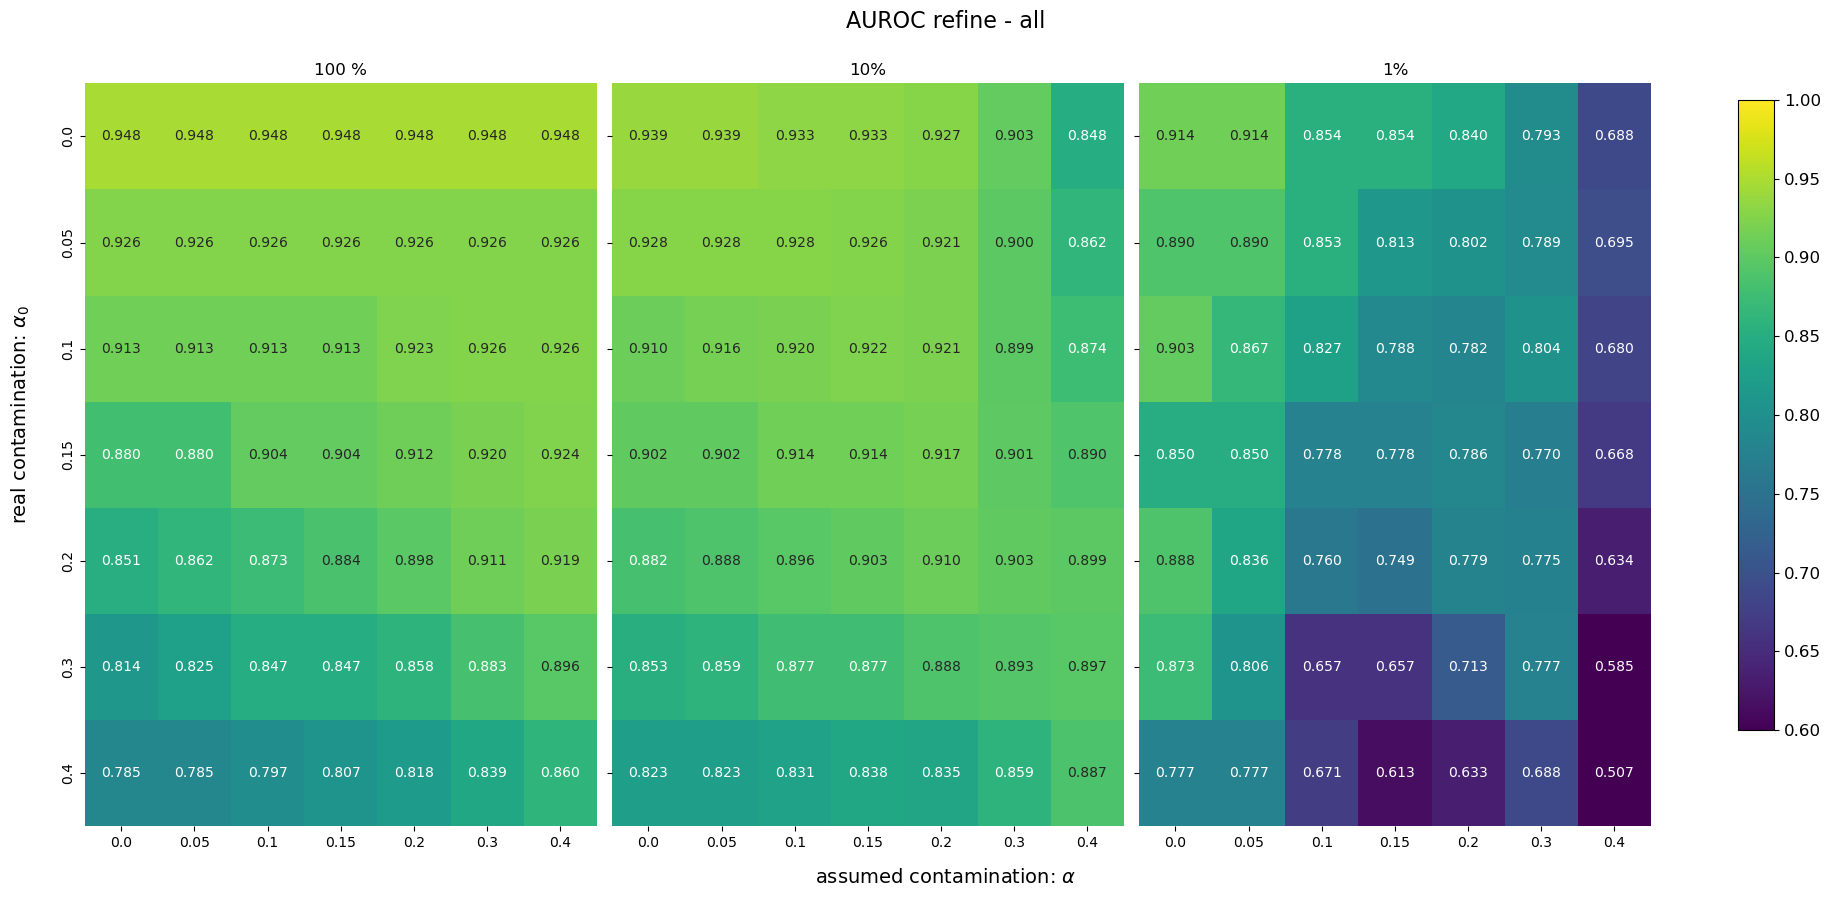

In [68]:
# plot multiple heatmaps

folderpathlist=['/root/LatentOE-AD/RESULTS/fmnist/','/root/LatentOE-AD/RESULTS/fmnist_0.1/','/root/LatentOE-AD/RESULTS/fmnist_0.01/']
model='refine'
mode='all'

overall_title = f'AUROC {model} - {mode}'
titles = ["100 %", "10%", "1%"]


contlist=[0.0,0.05,0.1,0.15,0.2,0.3,0.4]
df_list=[]
for folderpath in folderpathlist:
    df=get_heatmap_df(folderpath,model,contlist,mode=mode)
    df_list.append(df)


plot_heatmap_multiple(df_list, titles=titles,overall_title=overall_title, vmin_max=(0.6, 1))

In [1]:
import seaborn as sns
sns.color_palette("Paired")

/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [13]:
list_=sns.color_palette("Paired")

In [15]:
list_.as_hex

<bound method _ColorPalette.as_hex of [(0.6509803921568628, 0.807843137254902, 0.8901960784313725), (0.12156862745098039, 0.47058823529411764, 0.7058823529411765), (0.6980392156862745, 0.8745098039215686, 0.5411764705882353), (0.2, 0.6274509803921569, 0.17254901960784313), (0.984313725490196, 0.6039215686274509, 0.6), (0.8901960784313725, 0.10196078431372549, 0.10980392156862745), (0.9921568627450981, 0.7490196078431373, 0.43529411764705883), (1.0, 0.4980392156862745, 0.0), (0.792156862745098, 0.6980392156862745, 0.8392156862745098), (0.41568627450980394, 0.23921568627450981, 0.6039215686274509), (1.0, 1.0, 0.6), (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]>

In [11]:
hex=list_.as_hex()

In [12]:
print(hex)

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


sklearn on tsne

In [1]:
#laod whole dataset
import torch
from sklearn.manifold import TSNE
import numpy as np
import sys
print(sys.path)
sys.path.append('/root/LatentOE-AD')

from loader.LoadData import CIFAR10_feat , FMNIST_feat
from Extract_img_features import downsample_dataset
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from Additional_Code_BULE.utils.helper_functions import *

/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['/root/LatentOE-AD/Additional_Code_BULE', '/root/LatentOE-AD/Additional_Code_BULE/c', '/root/LatentOE-AD/Additional_Code_BULE/\\\\Users\\\\buehl\\\\git\\\\projects\\\\LatentOE-AD', '/root/anaconda3/envs/AutencoderTF/lib/python39.zip', '/root/anaconda3/envs/AutencoderTF/lib/python3.9', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/lib-dynload', '', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages']


2023-08-07 08:24:47.802507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 08:24:47.880384: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-07 08:24:47.896574: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-07 08:24:48.296510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
root="/root/LatentOE-AD/DATA/fmnist_features/"
trainset = torch.load(root+'trainset_2048.pt')
testset = torch.load(root+'testset_2048.pt')

In [3]:
# TSNE On fmnist trainset  ~ 2mins
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(testset[0])
label_names = ["t-shirt","trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","ankle-boot"]
label_dict={i:label_names[i] for i in range(len(label_names))}

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1],'label': testset[1]})#, 

In [19]:
# get the anomalies per class
# def all_indexdicts(trainset:torch.Tensor,classlist:list,fraction:float,trainset_name:str,contamination_rate:float=0.1,root:str="/root/LatentOE-AD/DATA/fmnist_features/",use_test_set:bool=False)->dict:

classlist=[0]
trainset_name=f'trainset_2048.pt'
fraction=0.1

indexdicts=all_indexdicts(trainset[0],classlist,fraction,trainset_name,contamination_rate=0.1)
#plot_all_tsne_per_class(tsne_result, indexdicts)

In [20]:
indexdicts

{0: {0: 2,
  1: 0,
  2: 0,
  3: 2,
  4: 0,
  5: 2,
  6: 2,
  7: 2,
  8: 2,
  9: 2,
  10: 0,
  11: 2,
  12: 2,
  13: 2,
  14: 2,
  15: 2,
  16: 2,
  17: 0,
  18: 2,
  19: 2,
  20: 2,
  21: 2,
  22: 2,
  23: 2,
  24: 2,
  25: 2,
  26: 0,
  27: 2,
  28: 2,
  29: 2,
  30: 2,
  31: 2,
  32: 2,
  33: 2,
  34: 0,
  35: 2,
  36: 2,
  37: 2,
  38: 2,
  39: 2,
  40: 2,
  41: 2,
  42: 2,
  43: 2,
  44: 1,
  45: 2,
  46: 2,
  47: 2,
  48: 0,
  49: 2,
  50: 2,
  51: 2,
  52: 2,
  53: 2,
  54: 2,
  55: 2,
  56: 2,
  57: 2,
  58: 2,
  59: 2,
  60: 2,
  61: 0,
  62: 2,
  63: 2,
  64: 0,
  65: 2,
  66: 0,
  67: 0,
  68: 2,
  69: 2,
  70: 2,
  71: 2,
  72: 2,
  73: 2,
  74: 2,
  75: 2,
  76: 2,
  77: 2,
  78: 2,
  79: 2,
  80: 2,
  81: 2,
  82: 1,
  83: 2,
  84: 2,
  85: 2,
  86: 2,
  87: 2,
  88: 2,
  89: 2,
  90: 2,
  91: 2,
  92: 2,
  93: 2,
  94: 2,
  95: 2,
  96: 2,
  97: 2,
  98: 2,
  99: 2,
  100: 2,
  101: 0,
  102: 2,
  103: 2,
  104: 2,
  105: 2,
  106: 2,
  107: 2,
  108: 2,
  109: 2,
  110: 

In [14]:
sum(indexdicts[1].values())

9000

In [5]:
# subset only the indexes from class 0
indexes_of_class = np.where(testset[1] == 0)[0]

y_class0=np.array(list(indexdicts[0].values()))[indexes_of_class]
tsne_class0=tsne_result[indexes_of_class]


In [6]:
np.array(list(indexdicts[0].values()))[indexes_of_class]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [49]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# License: BSD 3 clause

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs, make_moons
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 1_000
outliers_fraction = 0.1
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation
# to give similar results to the OneClassSVM
anomaly_algorithms = [
    (
        "Robust covariance",
        EllipticEnvelope(contamination=outliers_fraction, random_state=42),
    ),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]


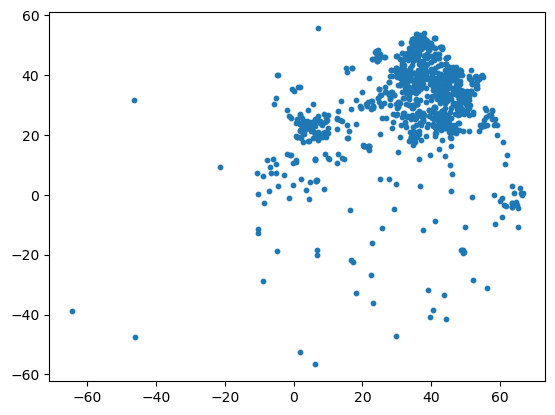

In [77]:
plt.scatter(tsne_class0[:, 0], tsne_class0[:, 1], s=10)

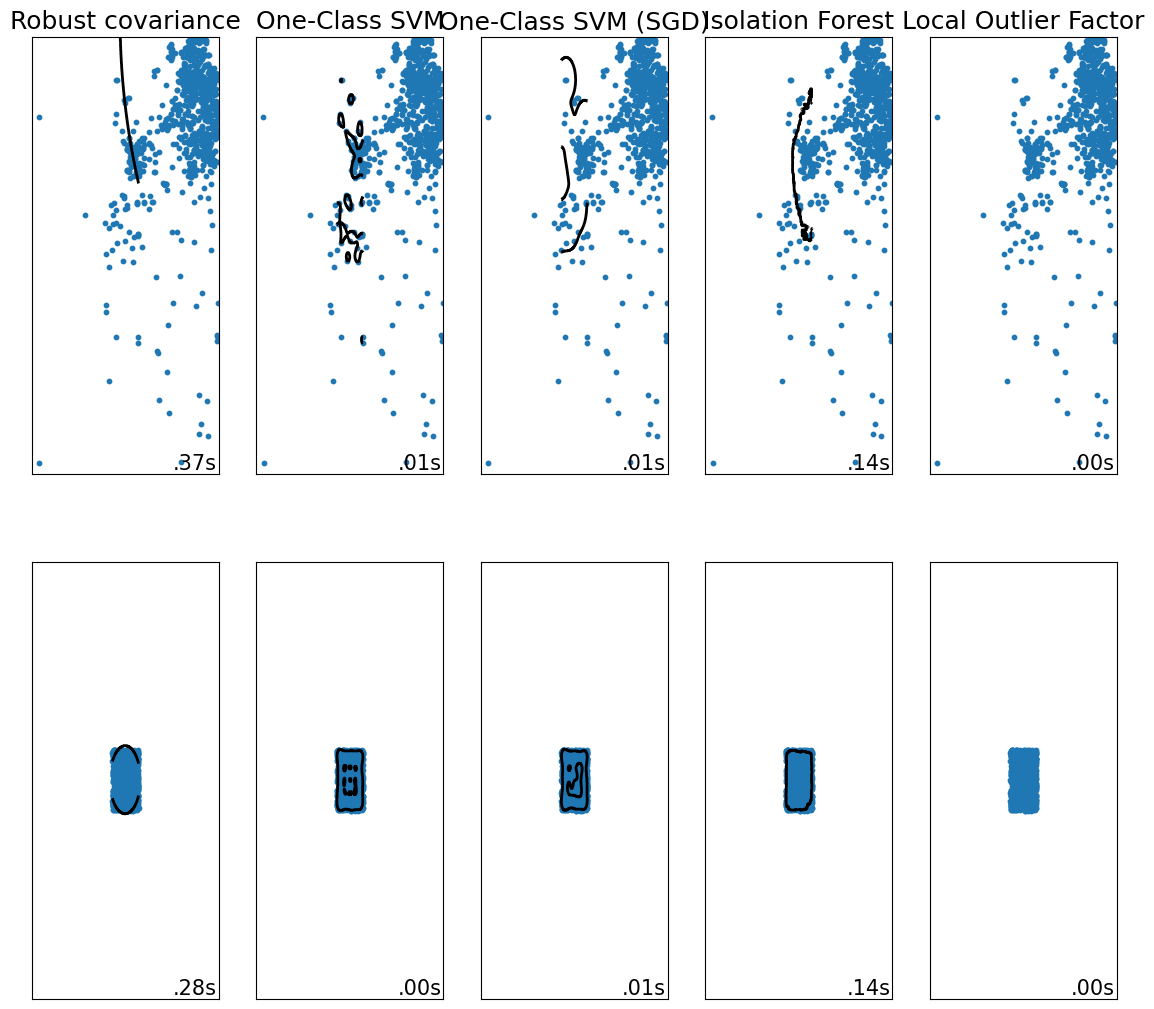

In [84]:

datasets = [
    tsne_class0,
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-50, 50, 150), np.linspace(-50, 50, 1000))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
# plt.subplots_adjust(
#     left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
# )


plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")


        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10)#, color=colors[(y_pred + 1) // 2])

        plt.xlim(-50, 50)
        plt.ylim(-50, 50)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

getting the indexes of the reduced data 

In [4]:
#load indexes of plot class0

loaded_idx_n = torch.load('/root/LatentOE-AD/DATA/idx_simple refine' + '/idx_n.pkl')


In [10]:
from Additional_Code_BULE.utils.helper_functions  import *


In [12]:
#laod whole dataset
import torch
from sklearn.manifold import TSNE
import numpy as np
import sys
print(sys.path)
sys.path.append('/root/LatentOE-AD')

from loader.LoadData import CIFAR10_feat , FMNIST_feat
from Extract_img_features import downsample_dataset
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from Additional_Code_BULE.utils.helper_functions import *

['/root/LatentOE-AD/Additional_Code_BULE', '/root/LatentOE-AD/Additional_Code_BULE/c', '/root/LatentOE-AD/Additional_Code_BULE/\\\\Users\\\\buehl\\\\git\\\\projects\\\\LatentOE-AD', '/root/anaconda3/envs/AutencoderTF/lib/python39.zip', '/root/anaconda3/envs/AutencoderTF/lib/python3.9', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/lib-dynload', '', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages', '/root/LatentOE-AD']


In [5]:
loaded_idx_n

tensor([2841,    0, 2697,  ..., 2747,   27,  350])

In [14]:
# TSNE On fmnist trainset  ~ 2mins
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(trainset[0])
label_names = ["t-shirt","trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","ankle-boot"]
label_dict={i:label_names[i] for i in range(len(label_names))}

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1],'label': trainset[1]})#, 

KeyError: 1

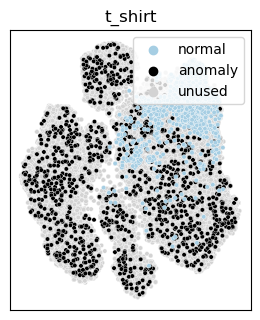

In [15]:
root="/root/LatentOE-AD/DATA/fmnist_features/"
trainset = torch.load(root+'trainset_2048.pt')
testset = torch.load(root+'testset_2048.pt')

classlist=[0]
fraction=0.3
trainset_name=f'trainset_2048_fraction_{fraction}.pt'


indexdicts=all_indexdicts(trainset[0],classlist,fraction,trainset_name,contamination_rate=0.4)
plot_all_tsne_per_class(tsne_result, indexdicts)